In [5]:
import random
import numpy as np
import matplotlib.pyplot as plt
from cs231n.data_utils import load_CIFAR10
import time
from __future__ import print_function
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [122]:
################################## SVM OBJECT ########################################
class linear_svm(object):
    
    def __init__(self, X, y, reg = 0.0):
        self.X = X
        self.y = y
        self.reg = reg
    
    def compute_loss_noloop(self, W, X, y, reg = 0.0):
        delta = 1.0
        loss_naive = 0.0
        
        scores = X.dot(W)
        z = np.arange(X.shape[0])

        corr_scor = np.reshape(scores[z,y], (scores[z,y].shape[0],1))
        corr_scor = np.broadcast_to(corr_scor, (corr_scor.shape[0],W.shape[1]))
        #print(scores[ix_(:,y)].shape)
        margins = np.maximum(scores - corr_scor + delta,0)
        margins[z,y] = 0
        
        loss_naive += np.sum(margins)
        
        return loss_naive/X.shape[0] + self.reg*np.linalg.norm(W)
        #return loss_naive
        
    def compute_loss_oneloop(self, W, X, y, reg = 0.0):
        delta = 1.0
        loss_naive = 0.0
        
        for i in range(len(X)):
            scores = X[i].dot(W)
            margins = np.maximum(scores - scores[y[i]] + delta,0)
            margins[y[i]] = 0
            loss_naive += np.sum(margins)
            
        return loss_naive/X.shape[0] + self.reg*np.linalg.norm(W)
    
    def compute_loss_twoloops(self, W, X, y, reg = 0.0):
        delta = 1.0
        loss_naive = 0.0
        
        for i in range(X.shape[0]):
            scores = X[i].dot(W)
            
            for j in range(len(scores)):
                if j != y[i]:
                    loss_naive += max(scores[j]-scores[y[i]] + delta, 0)
            
        return loss_naive/X.shape[0] + self.reg*np.linalg.norm(W)
    
    def lossgrad_twoloops(self, W, X, y, reg = 0.0):
        delta = 1.0
        loss_naive = 0.0
        
        dW = np.zeros(W.shape)
        
        for i in range(X.shape[0]):
            scores = X[i].dot(W)
            count = 0
            for j in range(len(scores)):
                if j != y[i]:
                    loss_naive += max(scores[j]-scores[y[i]] + delta, 0)
                    if(scores[j]-scores[y[i]]+delta > 0):
                        #print(dW[i].shape, dW.shape)
                        dW[:,j] += X[i].T
                        count += 1
            
            dW[:,y[i]] += - count*X[i].T
            
        return loss_naive/X.shape[0] + reg*np.linalg.norm(W), dW/X.shape[0]
                    
    def lossgrad_vectorized(self, W, X, y, reg = 0.0):
        delta = 1.0
        loss_naive = 0.0
        
        scores = X.dot(W)
        z = np.arange(X.shape[0])
        
        dW = np.zeros(W.shape)

        corr_scor = np.reshape(scores[z,y], (scores[z,y].shape[0],1))
        corr_scor = np.broadcast_to(corr_scor, (corr_scor.shape[0],W.shape[1]))
        #print(scores[ix_(:,y)].shape)
        margins = np.maximum(scores - corr_scor + delta,0)
        margins[z,y] = 0
        
        grad_count = (margins > 0).astype('float')
        #grad_count_yi = np.sum(grad_count.astype('float'),1)
        
        grad_count[z,y] = -1 * np.sum(grad_count.astype('float'),1)

        dW = np.dot(X.T, grad_count)
        
        loss_naive += np.sum(margins)
            
        return loss_naive/X.shape[0] + reg*np.linalg.norm(W), dW/X.shape[0] + 2*reg*W
        
    def num_grad(self, f, W):
        h = 0.0001
        grad = np.zeros(W.shape)
        
        it = np.nditer(W, flags=['multi_index'], op_flags=['readwrite'])
        
        while not it.finished:
            ix = it.multi_index
            fx = f(W)
            old_val = W[ix]
            W[ix] += h
            fxh = f(W)
            W[ix] = old_val
            grad[ix] = (fxh-fx)/h
            it.iternext()
            
        return grad
    
    def loss_function(self, W):
        return self.compute_loss_noloop(W, self.X, self.y)
    
    def svm_loss_naive(self, W, X, y, reg = 0.0):
        self.X = X
        self.y = y
        self.reg = reg
        grad = self.num_grad(self.loss_function, W)
        return grad, self.loss_function(W)
    
    def sample_batch(self,X, y, batch_size = 32):
        idx = np.random.randint(X.shape[0], size = batch_size)
    
        return X[idx,:], y[idx]

    def train_SGD(self, X, y, learning_rate = 1e-7, reg = 0.0, num_iters = 1000, batch_size = 32):
        
        W = np.random.randn(X.shape[1], 10)*0.0001
        
        loss_list = []
        #loss, grad = lossgrad_vectorized(W, X, y, reg)
        for i in range(num_iters):
                  X_batch, y_batch = self.sample_batch(X, y, batch_size)
                  
                  loss, grad = self.lossgrad_vectorized(W, X, y, reg)
                  loss_list.append(loss)
                  W += - learning_rate * grad
        
        loss_final, grad = self.lossgrad_vectorized(W, X, y, reg)
        
        loss_list.append(loss_final)
        return loss_list, W
                  
            
######################### SVM CLASS ###########################################33333

In [7]:
cifar_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar_dir)

print('Training Data:', X_train.shape)
print('Training Labels:', y_train.shape)
print('Testing Data:', X_test.shape)
print('Testing Labels:', y_test.shape)

Training Data: (50000L, 32L, 32L, 3L)
Training Labels: (50000L,)
Testing Data: (10000L, 32L, 32L, 3L)
Testing Labels: (10000L,)


In [8]:
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 100

#Validation Set
X_val = X_train[range(num_training, num_training+num_validation)]
y_val = y_train[range(num_training, num_training+num_validation)]

#Training Set
X_train = X_train[range(num_training)]
y_train = y_train[range(num_training)]

#Development Set
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

#Testing Set
X_test = X_test[range(num_test)]
y_test = y_test[range(num_test)]

print('Testing Data:', X_val.shape)
print('Testing Labels:', X_dev.shape)

X_train = np.reshape(X_train, (X_train.shape[0],-1))
X_test = np.reshape(X_test, (X_test.shape[0],-1))
X_val = np.reshape(X_val, (X_val.shape[0],-1))
X_dev = np.reshape(X_dev, (X_dev.shape[0],-1))

Testing Data: (1000L, 32L, 32L, 3L)
Testing Labels: (100L, 32L, 32L, 3L)


In [9]:
mean_image = np.mean(X_train, axis=0)

X_train -= mean_image
X_test -= mean_image
X_val -= mean_image
X_dev -= mean_image

X_train = np.hstack([X_train, np.ones((X_train.shape[0],1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0],1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0],1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0],1))])



In [71]:
####################Loss And Gradient###############################

W = np.random.randn(X_train.shape[1], 10)*0.0001
svm = linear_svm(X_train, y_train)

start = time.time()
loss, grad = svm.lossgrad_twoloops(W, X_train, y_train, 5.0)
end = time.time()
print("Grad with two loops takes : ", end - start)
loss2, grad2 = svm.lossgrad_vectorized(W, X_train, y_train, 5.0)
end2 = time.time()
print("Grad vectorized takes : ", end2 - end)

print(np.linalg.norm(grad - grad2))

Grad with two loops takes :  7.31999993324
Grad vectorized takes :  0.24799990654
1.68745599033e-09


In [22]:
########################Testing Loops####################################
print(X_train.shape, y_train.shape)

W = np.random.randn(X_train.shape[1], 10)*0.0001

print(np.linalg.norm(W))
svm = linear_svm()
eps = 0.00005

start = time.time()
loss = svm.compute_loss_oneloop(W, X_train, y_train)
end = time.time()
print("one loop takes ", end - start)
loss2 = svm.compute_loss_twoloops(W, X_train, y_train)
end2 = time.time()
print("Two loops take ", end2 - end)
loss3 = svm.compute_loss_noloop(W, X_train, y_train)
end3 = time.time()
print("No loop takes ", end3 - end2)


print('Loss = ', loss)
print('Loss = ', loss2)
print('Loss = ', loss3)

(49000L, 3073L) (49000L,)
0.0175896561567
one loop takes  1.13800001144
Two loops take  1.18499994278
No loop takes  0.114000082016
Loss =  9.23867834257
Loss =  9.23867834257
Loss =  9.23867834257


In [76]:
from cs231n.gradient_check import grad_check_sparse

loss, grad = svm.lossgrad_vectorized(W, X_train, y_train, 5.0)
f = lambda w: svm.lossgrad_vectorized(w, X_train, y_train, 5.0)[0]

grad_numerical = grad_check_sparse(f,W, grad)

Relative Error :  0.000129979971901
Relative Error :  0.00368445702616
Relative Error :  0.000625545782301
Relative Error :  0.000258196951986
Relative Error :  0.0396977462447
Relative Error :  0.0015945819691
Relative Error :  0.000269720833252
Relative Error :  0.00481153196495
Relative Error :  0.000980412478906
Relative Error :  0.000668393997241


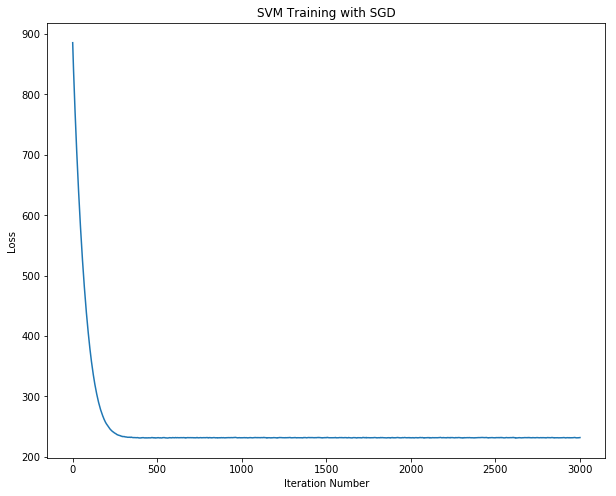

231.787952934


In [124]:
###################### STOCHASTIC GRADIENT DESCENT ###########################

#Implementing mini-batch gradient descent
svm = linear_svm(X_dev, y_dev)
loss_list, W_final = svm.train_SGD(X_dev, y_dev, 1e-7, 5e4, 3000,32)

plt.plot(loss_list)
plt.title("SVM Training with SGD")
plt.ylabel("Loss")
plt.xlabel("Iteration Number")
plt.show()

print(loss_list[-1])

In [125]:
y_pred_scores = np.dot(X_test, W_final)
y_pred = np.argmax(y_pred_scores, axis = 1)

num_correct = np.sum(y_pred == y_test)

print("Accuracy : ", num_correct.astype('float')/y_test.shape[0])
######SGD######

Accuracy :  0.204


In [128]:
###########################HYPERPARAMETER TUNING###########################################
learning_rates = [1e-7, 5e-6, 1e-5, 5e-5]
regularization_strengths = [1e3, 2.5e3, 5e3, 1e4, 2.5e4, 5e4, 5e5]

results = {}

for i in range(len(learning_rates)):
    for j in range(len(regularization_strengths)):
        loss_list, W_final = svm.train_SGD(X_train, y_train, learning_rates[i], regularization_strengths[j], 100, 32)
        
        y_pred_val = np.argmax(np.dot(X_val, W_final), axis=1)
        y_pred_train = np.argmax(np.dot(X_train, W_final), axis=1)
        
        results[(learning_rates[i], regularization_strengths[j])] = (np.sum(y_pred_train == y_train).astype('float')/y_train.shape[0], np.sum(y_pred_val == y_val).astype('float')/y_val.shape[0] )


for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
  
#print('best validation accuracy achieved during cross-validation: %f' % best_val)

        
        

lr 1.000000e-07 reg 1.000000e+03 train accuracy: 0.353673 val accuracy: 0.353000
lr 1.000000e-07 reg 2.500000e+03 train accuracy: 0.353673 val accuracy: 0.368000
lr 1.000000e-07 reg 5.000000e+03 train accuracy: 0.354000 val accuracy: 0.354000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.356510 val accuracy: 0.364000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.355000 val accuracy: 0.377000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.354755 val accuracy: 0.360000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.304449 val accuracy: 0.324000
lr 5.000000e-06 reg 1.000000e+03 train accuracy: 0.286796 val accuracy: 0.276000
lr 5.000000e-06 reg 2.500000e+03 train accuracy: 0.276061 val accuracy: 0.269000
lr 5.000000e-06 reg 5.000000e+03 train accuracy: 0.263449 val accuracy: 0.265000
lr 5.000000e-06 reg 1.000000e+04 train accuracy: 0.231102 val accuracy: 0.233000
lr 5.000000e-06 reg 2.500000e+04 train accuracy: 0.209449 val accuracy: 0.203000
lr 5.000000e-06 reg 5.000000

In [138]:
best_val = (1e-7, 2.5e4)

loss_list_best, W_best = svm.train_SGD(X_train, y_train, best_val[0], best_val[1], 1000, 32)



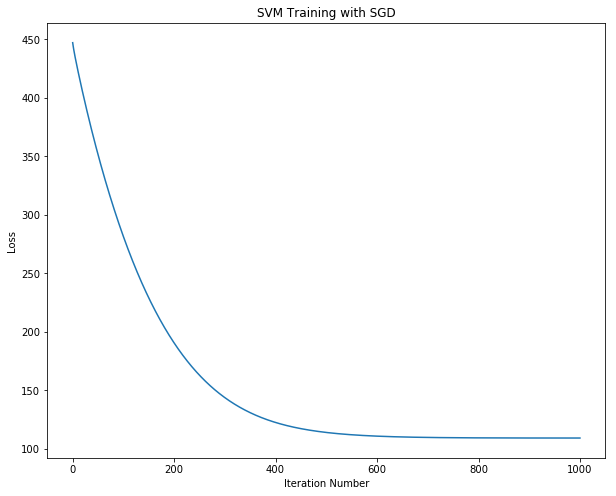

Best Accuracy Achieved on the Test Set :  0.384


In [153]:
plt.plot(loss_list_best)
plt.title("SVM Training with SGD")
plt.ylabel("Loss")
plt.xlabel("Iteration Number")
plt.show()

#print(loss_list_best[-1])

y_pred_scores = np.dot(X_val, W_best)
y_pred = np.argmax(y_pred_scores, axis = 1)

num_correct = np.sum(y_pred == y_val)

print("Best Accuracy Achieved on the Test Set : ", num_correct.astype('float')/y_test.shape[0])

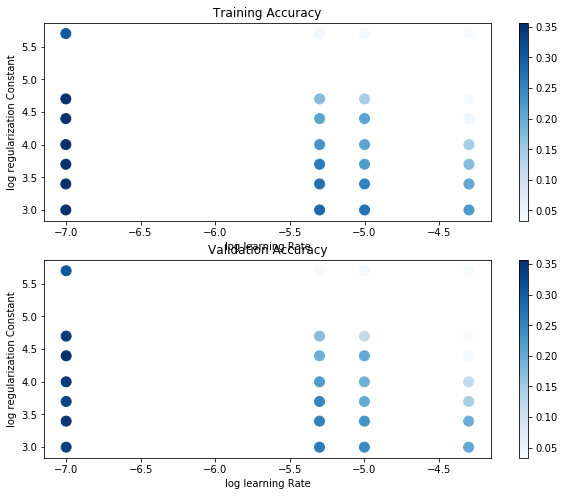

In [152]:
####################### SCATTER PLOT FOR HYPERPARAMETER TUNING ########################################
import math
import matplotlib.cm as cm

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2,1,1)
plt.scatter(x_scatter, y_scatter, marker_size, c = colors, cmap = cm.Blues)
plt.colorbar()
plt.xlabel('log learning Rate')
plt.ylabel('log regularization Constant')
plt.title('Training Accuracy')
colors2 = [results[x][1] for x in results]
plt.subplot(2,1,2)
plt.colorbar()
plt.scatter(x_scatter, y_scatter, marker_size, c = colors2, cmap = cm.Blues)

plt.xlabel('log learning Rate')
plt.ylabel('log regularization Constant')
plt.title('Validation Accuracy')
plt.show()

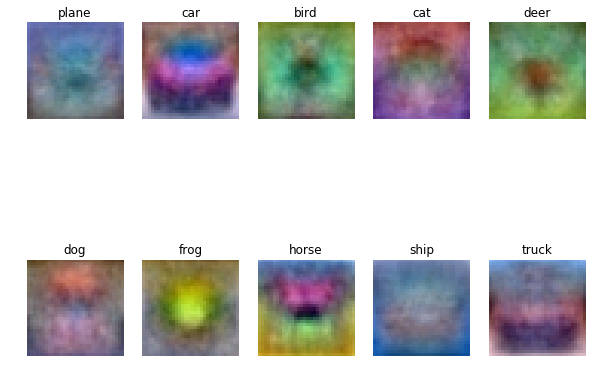

In [154]:
w = W_best[:-1,:]

w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])